In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio

plt.rcParams['ytick.left']=True
plt.rcParams['xtick.bottom']=True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False


from time import time

def timer(func):
    def wrapperfunc(*args):
        t0 = time()
        res = func(*args)
        print("%s took %1.3f seconds." % (func.__doc__,time()-t0))
        return res
    
    return wrapperfunc
    
    
"""
Code from Steve Bunton 
"""

# Define randomized SVD function
#@timer
def rSVD(X,r,q,p):
    """randomized svd"""
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1]
    P = np.random.randn(ny,r+p)
    Z = X @ P
    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced')

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=False)
    U = Q @ UY

    return U, S, VT

#@timer
def SVD(X):
    """svd"""
    return np.linalg.svd(X,full_matrices=False)

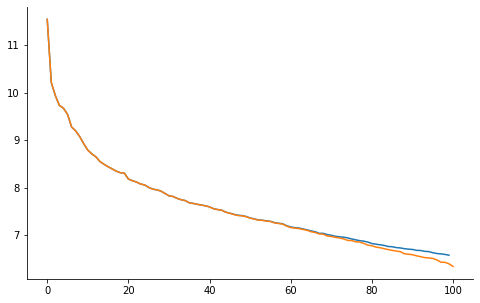

In [2]:
im = imageio.imread('img/IMG_1179.JPG')[:,:,0]

r = 100
Ur,Sr,Vr = rSVD(im,r,1,1)
U,S,V = SVD(im)
S = S[:r]

plt.figure(figsize=(8,5))
plt.plot(np.log(S))
plt.plot(np.log(Sr))

In [3]:
def AMSE(A,B):
    
    return np.mean((A-B)**2)


R = np.logspace(0,np.log10(1277),50)
Q = [0,1,3,5]


# regular svd
t0 = time()
U,S,Vh = SVD(im)
tsvd = time()-t0
tsvd = np.ones_like(R)*tsvd


# randomized svd
n_trials = 20

amse_av = {}
trsvd_av = {}
for q in Q:
    amse_av[q] = np.zeros_like(R)
    trsvd_av[q] = np.zeros_like(R)


for n in range(n_trials): 
    t_trial = time()
    
    # run for all r,q
    trsvd = {}
    amse = {}
    for q in Q:
        trsvd[q] = [] 
        amse[q] = []
        for r in R:
            r = int(r)

            t0 = time()
            Ur,Sr,Vr = rSVD(im,r,q,0)
            trsvd[q] += [time()-t0]

            Xref = U[:,:r] @ np.diag(S[:r]) @ Vh[:r]
            Xrand = Ur @ np.diag(Sr) @ Vr
            amse[q] += [AMSE(Xref,Xrand)]
            
    # gather trials
    for q in Q:
        amse_av[q] = np.vstack([amse_av[q],amse[q]])
        trsvd_av[q] = np.vstack([trsvd_av[q],trsvd[q]])
        
    print(n,'/',n_trials,'(%1.2fs)' % (time()-t_trial))


# average & std
amse_std = {}
trsvd_std = {}
for q in Q:
    amse_std[q] = np.std(amse_av[q],axis=0)
    amse_av[q] = np.mean(amse_av[q],axis=0)
    
    trsvd_std[q] = np.std(trsvd_av[q],axis=0)
    trsvd_av[q] = np.mean(trsvd_av[q],axis=0)
    

0 / 20 (41.78s)
1 / 20 (36.63s)
2 / 20 (36.39s)
3 / 20 (36.03s)
4 / 20 (35.86s)
5 / 20 (35.82s)
6 / 20 (38.31s)
7 / 20 (38.99s)
8 / 20 (39.78s)
9 / 20 (44.69s)
10 / 20 (39.93s)
11 / 20 (48.18s)
12 / 20 (39.67s)
13 / 20 (38.50s)
14 / 20 (44.34s)
15 / 20 (41.48s)
16 / 20 (42.17s)
17 / 20 (47.47s)
18 / 20 (44.65s)
19 / 20 (49.42s)


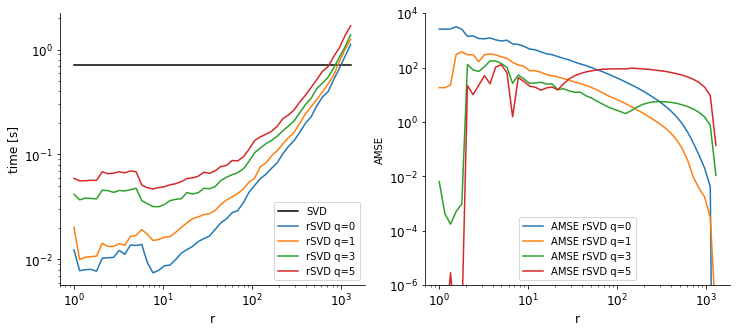

In [4]:
plt.rcParams.update({'xtick.labelsize': 'large'})
plt.rcParams.update({'ytick.labelsize': 'large'})

fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(R,tsvd,'black')
for q in Q:
    ax[0].loglog(R,trsvd_av[q])
    ax[0].set_ylabel('time [s]',fontsize=12)
    ax[0].set_xlabel('r',fontsize=12)
    
    ax[1].loglog(R,amse_av[q])
    ax[1].set_ylim([10**(-6),10**4])
    ax[1].set_xlabel('r',fontsize=12)
    ax[1].set_ylabel('AMSE')
    
    ax[0].legend(['SVD'] + ['rSVD q=%i' % q for q in Q])  
    ax[1].legend(['AMSE rSVD q=%i' % q for q in Q])  
    
    
plt.savefig('img/randomized_svd.png')

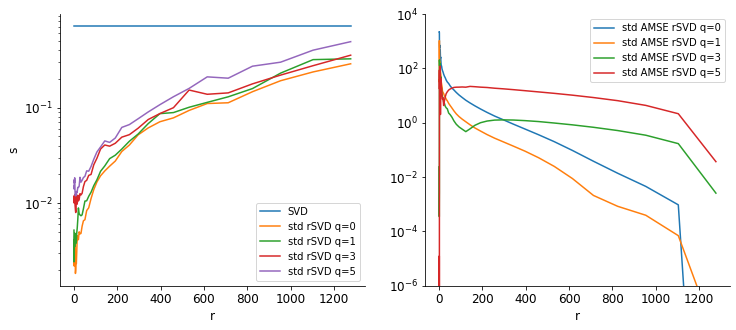

In [5]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(R,tsvd)
for q in Q:
    ax[0].semilogy(R,trsvd_std[q])
    ax[0].set_ylabel('s',fontsize=12)
    ax[0].set_xlabel('r',fontsize=12)
    
    ax[1].semilogy(R,amse_std[q])
    ax[1].set_ylim([10**(-6),10**4])
    ax[1].set_xlabel('r',fontsize=12)
    
    ax[0].legend(['SVD'] + ['std rSVD q=%i' % q for q in Q])  
    ax[1].legend(['std AMSE rSVD q=%i' % q for q in Q])  
    